<a href="https://colab.research.google.com/github/mingrui-liu/Hyperpigmentation-autograde/blob/main/siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import math
import shutil
import random

import tensorflow as tf
import numpy as np

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model, load_model,save_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D,Lambda,Concatenate,Input,BatchNormalization
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Nadam
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

image_size = 224
BATCH_SIZE = 32
data_path = "/content/drive/My Drive/Unilever/"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
def create_generators():

	def normalize(x):
		x /= 127.5
		x -= 1.
		return x

	def load_and_preprocess_image(path):
		image = tf.io.read_file(path)
		image = tf.image.decode_jpeg(image, channels=3)
		image = tf.image.resize(image, [image_size, image_size])
		image = tf.clip_by_value(image, 0.0, 255.0)
		image = tf.cast(image, dtype=tf.uint8)

		return image

	def load_file_from_disk(data_path):
		all_image_paths = sorted(glob.glob(data_path + "image_test/*.jpg"))

		# read the excel file
		MHPgrades = pd.read_excel(data_path + "MHPgrades.xlsx")
		grade = MHPgrades["Mottled hyperpigmentation"]

		#group and generate the lable
		all_image_labels = list(grade)
		all_label = []
		for grade in all_image_labels:
			if grade < 3.0:
				label = 2.5
			elif grade > 5.0:
				label = 5.5
			else:
				label = grade
			all_label.append(int(label * 2))

		label_to_index = dict((name, index) for index, name in enumerate(sorted(set(all_label))))
		all_labels = [label_to_index[grade] for grade in all_label]
		              
		# train test split 
		train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels,test_size = 0.1)

		return train_paths, test_paths, train_labels, test_labels


	def load_file_from_disk_with_additional_image(data_pat):
		all_image_paths_1 = sorted(glob.glob(data_path + "image_test/*.jpg"))
		all_image_paths_2 = sorted(glob.glob(data_path + "Additional_Images/*.jpg"))

		# read the excel file
		MHPgrades = pd.read_excel(data_path +"MHPgrades.xlsx",header = 0)
		MHPgrades2 = pd.read_excel(data_path +"SKN-APP-0452-MHPgrades.xlsx",header = 1)

		MHPgrades2 = MHPgrades2.dropna(axis = 0)
		MHPgrades2 = MHPgrades2.melt(id_vars=["Subject No.", "Side of Face"], 
		        var_name="VISIT", 
		        value_name="Mottled hyperpigmentation").sort_values(by = ['Subject No.','Side of Face'])

		grade1 = MHPgrades["Mottled hyperpigmentation"]

		#Manipulate excel file
		MHPgrades2.loc[MHPgrades2['VISIT'] == 'Baseline' , 'VISIT'] = '00'
		MHPgrades2.loc[MHPgrades2['VISIT'] == 'Week 4' , 'VISIT'] = '04'
		MHPgrades2.loc[MHPgrades2['VISIT'] == 'Week 8' , 'VISIT'] = '08'
		MHPgrades2.loc[MHPgrades2['VISIT'] == 'Week 12' , 'VISIT'] = '12'
		MHPgrades2.loc[MHPgrades2['VISIT'] == 'Week 16' , 'VISIT'] = '16'
		MHPgrades2.loc[MHPgrades2['VISIT'] == 'Week 17' , 'VISIT'] = '17'

		MHPgrades2.loc[MHPgrades2['Side of Face'] == 'Left' , 'Side of Face'] = 'L'
		MHPgrades2.loc[MHPgrades2['Side of Face'] == 'Right' , 'Side of Face'] = 'R'

		#match grade and images and make valid pair
		valid_path = []
		valid_label = []
		for index, row in MHPgrades2.iterrows():
		    id = str(row['Subject No.'] )
		    id = id.zfill(4)

		    side = row['Side of Face']
		   
		    visit = str(row['VISIT'])

		    grade = row['Mottled hyperpigmentation']
		  


		    output = [path for path in all_image_paths_2 if path.startswith('/content/drive/My Drive/Unilever/Additional_Images/P' + id + '_FACE_' + side + '_S00_VCR_S2_V00D00W' + visit)] 
		    if len(output)>0:
		      valid_path.append(output[0])
		      valid_label.append(grade)

		all_image_paths = all_image_paths_1 + valid_path
		all_image_labels = list(grade1) +  valid_label

		##Create label and zip dataset
		all_label = []
		for grade in all_image_labels:
		  if grade < 3.0:
		    label = 2.5
		  elif grade > 5.0:
		    label = 5.5
		  else:
		    label = grade
		  all_label.append(label)

		label_to_index = dict((name, index) for index, name in enumerate(sorted(set(all_label))))
		all_labels = [label_to_index[grade] for grade in all_label]

		train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels, test_size=0.1, random_state=1)
		train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.1, random_state=1)

		return train_paths,val_paths, test_paths, train_labels, val_labels, test_labels






	def create_ds(paths,labels):
		train_paths_1 = tf.data.Dataset.from_tensor_slices(paths)
		train_paths_2 = tf.data.Dataset.from_tensor_slices(paths)
		image_ds_1 = train_paths_1.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
		image_ds_2 = train_paths_2.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

		label_ds_1 = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
		label_ds_2 = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))



		image_label_ds_1 = tf.data.Dataset.zip((image_ds_1, label_ds_1))
		image_label_ds_1 = image_label_ds_1.shuffle(64)

		image_label_ds_2 = tf.data.Dataset.zip((image_ds_2, label_ds_2))
		image_label_ds_2 = image_label_ds_2.shuffle(64)
		

		image_label_ds = tf.data.Dataset.zip((image_label_ds_1, image_label_ds_2))

		return image_label_ds

	def detect(label1,label2):

		label = tf.cond(tf.equal(label1,label2), lambda: tf.constant(1.0), lambda: tf.constant(0.0))

		return label



	train_paths,val_paths, test_paths, train_labels, val_labels, test_labels = load_file_from_disk_with_additional_image(data_path)
  # here's our final training dataset
	train_ds = create_ds(train_paths,train_labels)
	val_ds = create_ds(val_paths,val_labels)
	test_ds = create_ds(test_paths,test_labels)


  #train
	train_ds = train_ds.cache()
	train_ds = train_ds.shuffle(buffer_size = 1024)
	train_ds = train_ds.repeat()
	train_ds = train_ds.map(lambda image_label1,image_label2: (tf.image.random_flip_left_right(image_label1[0]),tf.image.random_flip_left_right(image_label2[0]),image_label1[1],image_label2[1]),num_parallel_calls=AUTOTUNE)
	#train_ds = train_ds.map(lambda image1,image2,label1,label2:(randaugment.distort_image_with_randaugment(image1,num_layers = 1,magnitude = 2),
	#															randaugment.distort_image_with_randaugment(image2,num_layers = 1,magnitude = 2),
	#															label1,
	#															label2),num_parallel_calls=AUTOTUNE)
	train_ds = train_ds.map(lambda image1,image2,label1,label2 :(normalize(tf.cast(image1,tf.float32)),normalize(tf.cast(image2,tf.float32)),label1,label2),num_parallel_calls=AUTOTUNE)
	train_ds = train_ds.map(lambda image1,image2,label1,label2 :((image1,image2),detect(label1,label2)),num_parallel_calls=AUTOTUNE)
	train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

  #val
	val_ds = val_ds.cache()
	val_ds = val_ds.shuffle(buffer_size = 64)
	val_ds = val_ds.repeat()
	val_ds = val_ds.map(lambda image_label1,image_label2: (image_label1[0],image_label2[0],image_label1[1],image_label2[1]),num_parallel_calls=AUTOTUNE)
	val_ds = val_ds.map(lambda image1,image2,label1,label2 :(normalize(tf.cast(image1,tf.float32)),normalize(tf.cast(image2,tf.float32)),label1,label2),num_parallel_calls=AUTOTUNE)
	val_ds = val_ds.map(lambda image1,image2,label1,label2 :((image1,image2),detect(label1,label2)),num_parallel_calls=AUTOTUNE)
	val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

  #test
	test_ds = test_ds.cache()
	test_ds = test_ds.shuffle(buffer_size = 64)
	test_ds = test_ds.repeat()
	test_ds = test_ds.map(lambda image_label1,image_label2: (image_label1[0],image_label2[0],image_label1[1],image_label2[1]),num_parallel_calls=AUTOTUNE)
	test_ds = test_ds.map(lambda image1,image2,label1,label2 :(normalize(tf.cast(image1,tf.float32)),normalize(tf.cast(image2,tf.float32)),label1,label2),num_parallel_calls=AUTOTUNE)
	test_ds = test_ds.map(lambda image1,image2,label1,label2 :((image1,image2),detect(label1,label2)),num_parallel_calls=AUTOTUNE)
	test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)








	return train_ds,val_ds, test_ds

train_ds,val_ds, test_ds = create_generators()



In [ ]:
def create_base_model():
    conv_base = ResNet50(include_top = False, weights = 'imagenet',
                          input_shape = (224, 224, 3))


    #conv_base.trainable = False
    x = conv_base.output
    x = tf.keras.layers.Dropout(0.5)(x)
    embedding = GlobalAveragePooling2D()(x)
    embedding = Dense(128)(embedding)    
    return Model(conv_base.input, embedding)

def SiameseNetwork(base_model):
    """
    Create the siamese model structure using the supplied base and head model.
    """
    input_a = Input(shape=(224, 224, 3),name = "image1")
    input_b = Input(shape=(224, 224, 3),name = "image2")

    processed_a = base_model(input_a)
    processed_b = base_model(input_b)



    head = Concatenate()([processed_a, processed_b])
    head = Dense(1)(head)
    head = Activation(activation='sigmoid')(head)
    return Model([input_a, input_b], head)

base_model = create_base_model()



siamese_network = SiameseNetwork(base_model)

#siamese_network.save("test.h5")
lr_schedule  = tfa.optimizers.ExponentialCyclicalLearningRate(
                              initial_learning_rate=1e-8,
                              maximal_learning_rate=1e-6,
                              step_size=240,
                              )
opt = Adam(learning_rate=1e-8)

siamese_network.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy','RootMeanSquaredError'])



history = siamese_network.fit(train_ds,
      epochs = 100,
      steps_per_epoch = 50,
      validation_data = val_ds,
      validation_steps = 20)
      
      


Epoch 1/100
50/50 [==============================] - 38s 757ms/step - loss: 0.5409 - accuracy: 0.7706 - root_mean_squared_error: 0.4222 - val_loss: 2.8894 - val_accuracy: 0.1344 - val_root_mean_squared_error: 0.8966
Epoch 2/100
50/50 [==============================] - 35s 698ms/step - loss: 0.5422 - accuracy: 0.7656 - root_mean_squared_error: 0.4223 - val_loss: 2.9792 - val_accuracy: 0.1344 - val_root_mean_squared_error: 0.8990
Epoch 3/100
50/50 [==============================] - 36s 711ms/step - loss: 0.5548 - accuracy: 0.7538 - root_mean_squared_error: 0.4286 - val_loss: 3.2086 - val_accuracy: 0.1359 - val_root_mean_squared_error: 0.9040
Epoch 4/100
50/50 [==============================] - 35s 707ms/step - loss: 0.5286 - accuracy: 0.7750 - root_mean_squared_error: 0.4158 - val_loss: 3.4651 - val_accuracy: 0.1328 - val_root_mean_squared_error: 0.9095
Epoch 5/100
50/50 [==============================] - 35s 706ms/step - loss: 0.5500 - accuracy: 0.7500 - root_mean_squared_error: 0.4263 

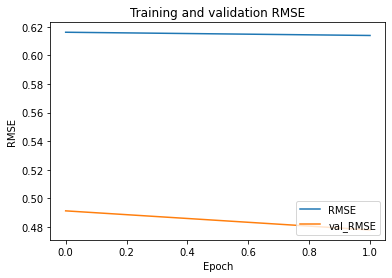

In [47]:
def plot_acc(history):
  
    plt.title('Training and validation root_mean_squared_error')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

def plo_loss(history):

    plt.title('Training and validation loss')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()


def plot_rmse(history):
  
    plt.title('Training and validation RMSE')
    plt.plot(history.history['root_mean_squared_error'], label='RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label = 'val_RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(loc='lower right')
    plt.show()

plot_loss(history)
plot_rmse(history)
plot_acc(history)
    


In [ ]:
prediction = model.predict_classes(test_ds)

classes=[0,1,2,3,4,5,6]
con_mat  = tf.math.confusion_matrix(
    test_labels, prediction, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)


import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [48]:
loss, accuracy, RMSE = siamese_network.evaluate(test_ds,steps= 32)
print("Loss: {:1.2}".format(loss))
print("RMSE: {:1.2}".format (RMSE))
print("Accuracy: {:2.2%}".format(accuracy))



32/32 [==============================] - 9s 279ms/step - loss: 0.6442 - accuracy: 0.6406 - root_mean_squared_error: 0.4755
RMSE: 0.4754846692085266


In [55]:
from keras.models import load_model

siamese_network.save('/content/drive/MyDrive/Capstone/progress2/project/siamese_network.h5')  # creates a HDF5 file 'my_model.h5'